In [39]:
import pandas as pd 
import numpy as np
import csv
import os.path
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches

In [40]:
#Importing the data from the csv file in the Data folder and turn them into pandas dataframe. Some of them needs to be converted to int datatype to combina all the datasets because some of the dataframe is type object when read'''
champions = pd.read_csv(r'./Data/champs.csv')
matches = pd.read_csv(r'./Data/matches.csv', dtype = np.array(np.dtype('int16')))
stats1 = pd.read_csv(r'./Data/stats1.csv', dtype = np.array(np.dtype('int16')))
stats1_2 = pd.read_csv(r'./Data/stats1-2.csv', dtype = np.array(np.dtype('int16')))
stats1_3 = pd.read_csv(r'./Data/stats1-3.csv', dtype = np.array(np.dtype('int16')))
stats2 = pd.read_csv(r'./Data/stats2.csv', dtype = np.array(np.dtype('int16')))
stats2_2 = pd.read_csv(r'./Data/stats2-2.csv', dtype = np.array(np.dtype('int16')))

#Appending stats1 and stats2 dataset
stats1_2 = pd.concat([stats1_2,stats1_3],sort = False)#stats1_2.concat(stats1_3,, sort = False);
stats1 = pd.concat([stats1,stats1_2],sort = False)#stats1.concat(stats1_2);
stats2 = pd.concat([stats2,stats2_2],sort = False)#stats2.concat(stats2_2);
stats =pd.concat([stats1,stats2],sort = False)# stats1.concat(stats2)

In [41]:
#Merge particpants with appropriate champion name. test
participants = pd.read_csv(r'./Data/participants.csv', dtype = np.array(np.dtype('int16')))
#Rename the column of the participants dataframe from id to play_id and championid to id for better clarification. inplace so no extra copy is made
participants.rename(columns ={'id': 'player_id','championid':'id'}, inplace = True)
#Merge the participants dataset with the champions dataset based on the championid. This is similar to left join in SQL 
champions['id'] = champions['id'].astype(str).astype(int)
participants['id'] = participants['id'].astype(str).astype(int)
participants = pd.concat([participants.set_index('id'),champions.set_index('id')], axis=1, join='inner').reset_index()
#Delete the column role because I think it's irrelevant for now 

#Rename the stats data set column from id to player_id and inplace 
stats.rename(columns={'id':'player_id'},inplace = True)
#Convert the player_id column to int because it is currently type Object and we cannot manipulate object type column and int type column too easily 
stats['player_id'] = stats['player_id'].astype(int)
participants['player_id'] = participants['player_id'].astype(str).astype(int)
#merge the participants dataset with stats dataset based on the player_id. This makes participants a massive dataset with lots of columns and champions that each player uses
participants = participants.merge(stats, how = 'left', on = 'player_id')
#This is me testing out the gorupby but this will group the champion based on their name and count how many win and lose they have. Win and lose are represented with 0 and 1 
champsFreq = participants.groupby(['name','win'])['win'].count()

#Turn it into a dataframe
champsFreq = pd.DataFrame(champsFreq)
#Add Suffix Count to the second column. When we groupby, it creates columns with same name and it's difficult to select columns so I add a letter to the column with the number of wins and lose for easy access to the dataframe
champsFreq = champsFreq.add_suffix('Count').reset_index()
#Converting the columns from object to int type
champsFreq['win'] = champsFreq['win'].astype(str).astype(int)

In [42]:
#Get the lose values
loseValues = champsFreq.loc[champsFreq['win'] == 0,'winCount'].reset_index()
loseValues.rename(columns = {'winCount': 'lose'}, inplace = True)
loseValues = loseValues['lose']

#Get the win values
winValues = champsFreq.loc[champsFreq['win'] == 1, 'winCount'].reset_index()
winValues.rename(columns = {'winCount':'win'}, inplace = True)
winValues = winValues['win']

#Get the champion name
championName = champsFreq['name'].drop_duplicates().reset_index()
championName = championName['name']

In [44]:
#get the match id specific columns good for evaluation 
matches.rename(columns = {'id': 'matchid'}, inplace = True)
matches = matches[['matchid','seasonid','duration','version']]
#get the match data for season 8 only
matches['seasonid'] = matches['seasonid'].astype(int)
matches = matches[matches['seasonid'] == 8]
matches['matchid'] = matches['matchid'].astype(int)

In [45]:
#get participants columns that needed 
participants_match = participants[['id','player_id','matchid','player','name','win']]
participants_match['matchid'] = participants_match['matchid'].astype(int)

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [46]:
#merge on matchid 
new_match = pd.merge(matches, participants_match, on = 'matchid')
new_match['player'] = new_match['player'].astype(int)

In [47]:
#Remake the chamions dataframe with win and lose values for each champion to make a clearer dataframe
champions_values = pd.DataFrame([championName, winValues, loseValues]).transpose()

In [48]:
#look for inconsistant data in the new_match dataframe
toDel = []
test = [1,2,3,4,5,6,7,8,9,10]
listVal = list(dict.fromkeys(new_match['matchid']))

In [49]:
for i in listVal:
    listPlayer = list(new_match['player'].loc[new_match['matchid'] == i])
    #check if the list follows the same order of ten players
    if listPlayer == test:
        continue
    else:
        toDel.append(i)

In [50]:
#Remove all bad rows
new_match = new_match[~new_match.matchid.isin(toDel)]

In [51]:
#sort the champions_values based on win rate
testPlt = champions_values.sort_values(by = ['win'], ascending = [False])

In [52]:
#Get the top 5 with the highest win rate
testChamp = testPlt[0:5]

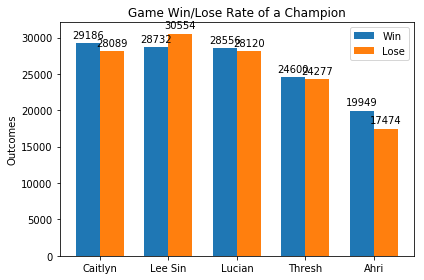

In [54]:
#plotting it
labels = list(testChamp['name'])
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, testChamp['win'], width, label='Win')
rects2 = ax.bar(x + width/2, testChamp['lose'], width, label='Lose')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Outcomes')
ax.set_title('Game Win/Lose Rate of a Champion')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

In [55]:
new_match

,matchid,seasonid,duration,version,id,player_id,player,name,win
0,10,8,1909,7.10.187.9675,19,9,1,Warwick,0
1,10,8,1909,7.10.187.9675,267,10,2,Nami,0
2,10,8,1909,7.10.187.9675,119,11,3,Draven,0
3,10,8,1909,7.10.187.9675,114,12,4,Fiora,0
4,10,8,1909,7.10.187.9675,112,13,5,Viktor,0
5,10,8,1909,7.10.187.9675,72,14,6,Skarner,1
6,10,8,1909,7.10.187.9675,3,15,7,Galio,1
7,10,8,1909,7.10.187.9675,103,16,8,Ahri,1
8,10,8,1909,7.10.187.9675,222,17,9,Jinx,1
9,10,8,1909,7.10.187.9675,161,18,10,VelKoz,1


In [56]:
listVersion = list(dict.fromkeys(new_match['version']))

['7.10.187.9675',
 '7.9.186.8155',
 '7.9.186.1051',
 '7.8.184.113',
 '7.7.183.8394',
 '7.7.182.1428',
 '7.6.181.2079',
 '7.6.180.6903',
 '7.5.178.6844',
 '7.4.178.5050',
 '7.4.176.9828',
 '7.3.175.271',
 '7.2.174.829',
 '7.1.172.6393',
 '7.1.171.6847',
 '6.24.169.4424',
 '6.24.168.1268',
 '6.23.166.2676',
 '6.22.165.9605',
 '6.22.165.3566',
 '6.22.165.583',
 '7.2.173.3544',
 '7.11.189.942']

In [58]:
new_match[new_match['version'] == '7.10.187.9675']

,matchid,seasonid,duration,version,id,player_id,player,name,win
0,10,8,1909,7.10.187.9675,19,9,1,Warwick,0
1,10,8,1909,7.10.187.9675,267,10,2,Nami,0
2,10,8,1909,7.10.187.9675,119,11,3,Draven,0
3,10,8,1909,7.10.187.9675,114,12,4,Fiora,0
4,10,8,1909,7.10.187.9675,112,13,5,Viktor,0
5,10,8,1909,7.10.187.9675,72,14,6,Skarner,1
6,10,8,1909,7.10.187.9675,3,15,7,Galio,1
7,10,8,1909,7.10.187.9675,103,16,8,Ahri,1
8,10,8,1909,7.10.187.9675,222,17,9,Jinx,1
9,10,8,1909,7.10.187.9675,161,18,10,VelKoz,1


In [61]:
new_match[new_match['version'] == '7.11.189.942']

,matchid,seasonid,duration,version,id,player_id,player,name,win
1730908,185931,8,1786,7.11.189.942,240,1849061,1,Kled,1
1730909,185931,8,1786,7.11.189.942,1,1849062,2,Annie,1
1730910,185931,8,1786,7.11.189.942,11,1849063,3,Master Yi,1
1730911,185931,8,1786,7.11.189.942,40,1849064,4,Janna,1
1730912,185931,8,1786,7.11.189.942,22,1849065,5,Ashe,1
1730913,185931,8,1786,7.11.189.942,51,1849066,6,Caitlyn,0
1730914,185931,8,1786,7.11.189.942,60,1849067,7,Elise,0
1730915,185931,8,1786,7.11.189.942,63,1849068,8,Brand,0
1730916,185931,8,1786,7.11.189.942,59,1849069,9,Jarvan IV,0
1730917,185931,8,1786,7.11.189.942,25,1849070,10,Morgana,0
